In [1]:
# %% slideshow={"slide_type": "slide"}
# Kat

In [2]:
# Load packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns             # NEED TO CREATE AN ENV THAT HAS SEABORN IN THE SERVER
import numpy as np
import os
import libpysal as lps 
from libpysal.weights import W  # Also need to put these on the server too 
# from esda.getisord import G 
from esda.getisord import G_Local

# Remove max columns
pd.set_option('display.max_columns', None)


## Read in the Data

Select the `base_dir` that's appropriate for your device. The top `base_dir` works from the workbench-2 server. The second `base_dir` works from my local device

If you load all datasets at once, it will take about a minute to read in. If you are troubleshooting and want it to load faster, comment out the shapefile data


In [3]:
# Import data
base_dir = "/capstone/justice40"
# base_dir = "~/MEDS/justice40/data-exploration"

# Complete 2.0 USA file
usa_v2 = pd.read_csv(os.path.join(base_dir, "data", "usa_v2.csv"))

# 2.0 communities files (from current CEJST website)
comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))

# Version 2.0 shapefile data
v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "2.0-codebook.csv"))
v2_geo = gpd.read_file(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "usa", "usa.shp"))


/tmp/ipykernel_625164/26812626.py:6: DtypeWarning: Columns (1,2,3,79,80,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  usa_v2 = pd.read_csv(os.path.join(base_dir, "data", "usa_v2.csv"))
/tmp/ipykernel_625164/26812626.py:9: DtypeWarning: Columns (18,29,73,75,88,134) have mixed types. Specify dtype option on import or set low_memory=False.
  comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))


In [4]:
# Filter df to louisiana 
louisiana = comm_v2[comm_v2['State/Territory'] == 'Louisiana']

# Narrow down to desired columns
louis_small = louisiana[['Census tract 2010 ID', 'Total threshold criteria exceeded', 'Total categories exceeded', 'Identified as disadvantaged without considering neighbors', 'Identified as disadvantaged based on neighbors and relaxed low income threshold only', 'Identified as disadvantaged', 'Percentage of tract that is disadvantaged by area', 'Share of neighbors that are identified as disadvantaged', 'Total population']]
louis_small = louis_small.rename(columns={
    'Census tract 2010 ID': 'tract_id',
    'Total threshold criteria exceeded':'total_criteria', 
    'Total categories exceeded':'total_burdens', 
    'Identified as disadvantaged without considering neighbors':'dac_wo_neighbors', 
    'Identified as disadvantaged based on neighbors and relaxed low income threshold only':'dac_relaxed_low_income', 
    'Identified as disadvantaged':'dac', 
    'Percentage of tract that is disadvantaged by area':'percent_area_dac', 
    'Share of neighbors that are identified as disadvantaged':'share_of_dac_neighbors', 
    'Total population':'total_population'
})
louis_small.head()

,tract_id,total_criteria,total_burdens,dac_wo_neighbors,dac_relaxed_low_income,dac,percent_area_dac,share_of_dac_neighbors,total_population
28303,22001960100,5,4.0,True,False,True,100,25.0,5804.0
28304,22001960200,0,0.0,False,False,False,0,55.0,5514.0
28305,22001960300,0,0.0,False,False,True,100,55.0,3501.0
28306,22001960400,0,0.0,False,False,False,0,57.0,7256.0
28307,22001960500,0,0.0,False,False,False,0,55.0,7624.0


In [5]:
usa_small = usa_v2[['GEOID10_TRACT', 'Workforce Factor (Definition N)', 'Total categories exceeded', 'Definition N (communities)', 'Percentage of tract that is disadvantaged']]
usa_small = usa_small.rename(columns={'GEOID10_TRACT': 'tract_id', 
                                    'Workforce Factor (Definition N)':'workforce_burd',
                                    'Total categories exceeded':'burden_total', 
                                    'Definition N (communities)': 'dac_status', 
                                    'Percentage of tract that is disadvantaged':'percentage_dac'})

In [6]:
# Examine shapefile
v2_geo.head()

,GEOID10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,EPLR_PFS,HBF_PFS,LLEF_PFS,LIF_PFS,LMI_PFS,PM25F_PFS,HSEF,P100_PFS,P200_I_PFS,AJDLI_ET,LPF_PFS,KP_PFS,NPL_PFS,RMP_PFS,TSDF_PFS,TPF,TF_PFS,UF_PFS,WF_PFS,UST_PFS,N_WTR,N_WKFC,N_CLT,N_ENY,N_TRN,N_HSG,N_PLN,N_HLTH,SN_C,SN_C_V10,SN_GRAND,SN_T,DLI,ALI,PLHSE,LMILHSE,ULHSE,EPL_ET,EAL_ET,EBL_ET,EB_ET,PM25_ET,DS_ET,TP_ET,LPP_ET,HRS_ET,KP_ET,HB_ET,RMP_ET,NPL_ET,TSDF_ET,WD_ET,UST_ET,DB_ET,A_ET,HD_ET,LLE_ET,UN_ET,LISO_ET,POV_ET,LMI_ET,IA_LMI_ET,IA_UN_ET,IA_POV_ET,TC,CC,IAULHSE,IAPLHSE,IALMILHSE,IALMIL_78,IAPLHS_79,IAULHS_80,LHE,IALHE,IAHSEF,N_CLT_EOMI,N_ENY_EOMI,N_TRN_EOMI,N_HSG_EOMI,N_PLN_EOMI,N_WTR_EOMI,N_HLTH_90,N_WKFC_91,FPL200S,FPL200P,N_WKFC_94,TD_ET,TD_PFS,FLD_PFS,WFR_PFS,FLD_ET,WFR_ET,ADJ_ET,IS_PFS,IS_ET,AML_ET,FUDS_RAW,FUDS_ET,IMP_FLG,DM_B,DM_AI,DM_A,DM_HI,DM_T,DM_W,DM_H,DM_O,AGE_10,AGE_MIDDLE,AGE_OLD,TA_COU_119,TA_COUNT_C,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,geometry
0,01073001100,Alabama,Jefferson County,0.96,0.85,0.72,0.84,0.86,0.21,0.78,0.61,0.64,0.97,0.12,0.82,0.82,0.08,0.62,0.65,1,0.39,0.21,0.75,0.90,0.48,4781.0,0.39,0.02,0.96,0.52,1,0,0,0,0,1,1,1,1,0,0,None,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,5,4.0,0,0,0,NaN,NaN,NaN,0,0,NaN,0,0,0,1,1,1,1,0,1,NaN,0,0,0.45,0.49,0.84,0,0,0,0.26,0,0,None,0,0,0.96,0.01,0.0,0.0,0.00,0.01,0.00,0.00,0.13,0.66,0.20,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-86.88244 33.55233, -86.88187 33.552..."
1,01073001400,Alabama,Jefferson County,0.98,0.83,0.92,0.93,0.97,0.08,0.91,0.55,0.34,0.96,0.58,0.83,0.83,0.17,0.86,0.78,1,0.84,0.50,0.86,0.87,0.80,1946.0,0.95,0.90,0.84,0.64,0,1,1,1,1,1,0,1,1,1,0,None,1,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,9,6.0,0,0,0,NaN,NaN,NaN,1,0,NaN,1,1,1,1,0,0,1,1,1,NaN,1,0,0.37,0.88,0.33,0,0,1,0.55,0,0,None,0,0,0.91,0.00,0.0,0.0,0.00,0.00,0.06,0.07,0.08,0.72,0.18,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-86.84088 33.52759, -86.83782 33.528..."
2,01073002000,Alabama,Jefferson County,0.98,0.97,0.94,0.76,0.93,0.08,0.64,0.63,0.89,0.95,0.54,0.93,0.81,0.23,0.98,0.96,1,0.82,0.59,0.75,0.37,0.73,4080.0,0.61,0.94,0.83,0.81,0,1,0,1,0,0,0,1,1,1,0,None,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1,0,0,0,8,3.0,0,0,0,NaN,NaN,NaN,1,0,NaN,0,1,0,0,0,0,1,1,1,NaN,1,0,0.52,0.84,0.33,0,0,1,0.23,0,0,None,0,0,0.63,0.00,0.0,0.0,0.00,0.27,0.07,0.02,0.15,0.71,0.12,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-86.71390 33.53930, -86.71435 33.539..."
3,01073003802,Alabama,Jefferson County,0.95,0.91,0.62,0.79,0.97,0.07,0.90,0.55,0.87,0.86,0.12,0.79,0.83,0.14,0.73,0.85,1,0.83,0.94,0.60,0.74,0.68,5291.0,0.49,0.87,0.16,0.85,0,0,1,1,0,1,0,1,1,1,0,None,1,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,6,4.0,0,0,0,NaN,NaN,NaN,1,0,NaN,1,1,0,1,0,0,1,0,1,NaN,1,0,0.75,0.82,0.33,0,0,1,0.49,0,0,None,0,0,0.97,0.00,0.0,0.0,0.00,0.01,0.00,0.00,0.14,0.72,0.13,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-86.90317 33.47177, -86.90284 33.472..."
4,01073004000,Alabama,Jefferson County,0.99,0.96,0.96,0.86,0.98,NaN,0.95,0.55,0.92,0.99,0.71,0.98,0.84,0.17,0.95,0.96,1,0.67,0.67,0.71,0.86,0.73,2533.0,0.49,0.98,0.19,0.66,0,1,1,1,0,1,0,1,1,1,0,None,1,1,1,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,1,1,0,1,1,0,0,0,11,5.0,0,0,0,NaN,NaN,NaN,1,0,NaN,1,1,0,1,0,0,1,1,1,NaN,1,0,0.33,0.80,0.33,0,0,1,0.68,0,0,None,0,0,0.85,0.00,0.0,0.0,0.04,0.06,0.06,0.00,0.06,0.68,0.24,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-86.85463 33.48754, -86.85554 33.486..."


In [7]:
# Filter shapefile to LA and select desired columns
louis_geo = v2_geo[v2_geo['SF'] == 'Louisiana']
louis_geo = louis_geo[['GEOID10', 'geometry']]

# Change census tract id type so we can merge later on
louis_geo['GEOID10'] = louis_geo['GEOID10'].astype('int64')
louis_geo

,GEOID10,geometry
28294,22071001744,"POLYGON ((-89.99543 30.03304, -89.99558 30.033..."
28295,22071001746,"POLYGON ((-89.96027 30.06396, -89.96190 30.065..."
28296,22071001745,"POLYGON ((-89.96018 30.05478, -89.96122 30.054..."
28297,22071001747,"POLYGON ((-89.96312 30.02792, -89.96359 30.027..."
28298,22071001748,"POLYGON ((-89.96312 30.02792, -89.96218 30.028..."
...,...,...
29437,22109001400,"POLYGON ((-90.95839 29.17932, -90.95905 29.177..."
29438,22109000600,"POLYGON ((-90.64882 29.59345, -90.64885 29.593..."
29439,22019000200,"POLYGON ((-93.24373 30.25268, -93.24341 30.252..."
29440,22019001100,"POLYGON ((-93.20546 30.17863, -93.20546 30.178..."


<Axes: >

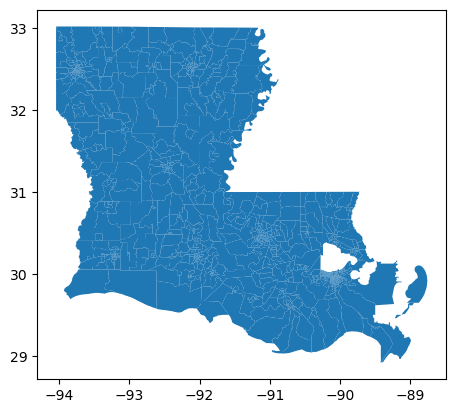

In [8]:
louis_geo.plot()

In [9]:
# Merge geometry df and burden df
louis_complete = pd.merge(louis_small, louis_geo, left_on='tract_id', right_on='GEOID10')
louis_complete

,tract_id,total_criteria,total_burdens,dac_wo_neighbors,dac_relaxed_low_income,dac,percent_area_dac,share_of_dac_neighbors,total_population,GEOID10,geometry
0,22001960100,5,4.0,True,False,True,100,25.0,5804.0,22001960100,"POLYGON ((-92.24001 30.43670, -92.23961 30.436..."
1,22001960200,0,0.0,False,False,False,0,55.0,5514.0,22001960200,"POLYGON ((-92.52976 30.33379, -92.53014 30.333..."
2,22001960300,0,0.0,False,False,True,100,55.0,3501.0,22001960300,"POLYGON ((-92.62775 30.35020, -92.62805 30.350..."
3,22001960400,0,0.0,False,False,False,0,57.0,7256.0,22001960400,"POLYGON ((-92.54287 30.33303, -92.54229 30.333..."
4,22001960500,0,0.0,False,False,False,0,55.0,7624.0,22001960500,"POLYGON ((-92.29686 30.31968, -92.29686 30.319..."
...,...,...,...,...,...,...,...,...,...,...,...
1143,22125951800,0,0.0,False,False,False,0,42.0,7588.0,22125951800,"POLYGON ((-91.33182 30.89296, -91.32320 30.891..."
1144,22127960100,0,0.0,False,False,True,100,75.0,3407.0,22127960100,"POLYGON ((-92.72684 32.02363, -92.72687 32.023..."
1145,22127960200,0,0.0,False,False,False,0,77.0,6183.0,22127960200,"POLYGON ((-92.72693 32.02412, -92.72688 32.023..."
1146,22127960300,4,4.0,True,False,True,100,33.0,2315.0,22127960300,"POLYGON ((-92.63379 31.94564, -92.63378 31.945..."


In [10]:
# At some point, we lost our geodataframe type. Add it back so we can map
# I think this was because of the merge, I just didn't wanna go back and fix it
louis_complete = gpd.GeoDataFrame(louis_complete)

In [11]:
louis_complete.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

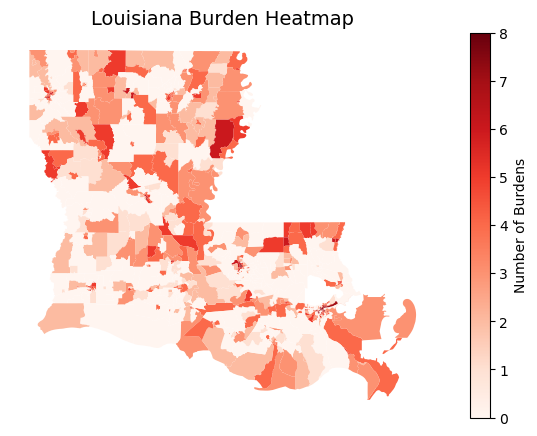

In [12]:
# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title('Louisiana Burden Heatmap',
            fontsize=14)

# Plot NY state and color by number of spills 
louis_complete.plot(ax=ax,
                column='total_burdens',
                cmap='Reds',
                legend=True,
                legend_kwds={
                    'label':'Number of Burdens'
                })
plt.show()

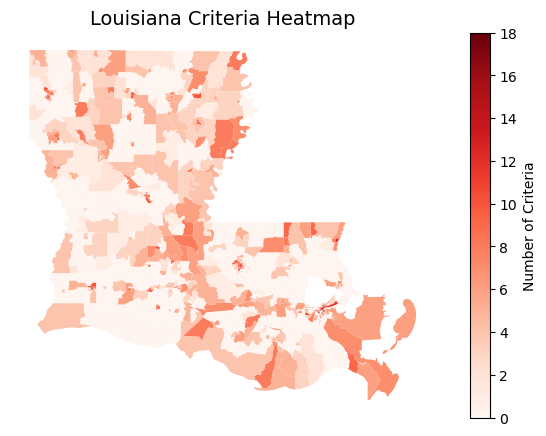

In [13]:
# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title('Louisiana Criteria Heatmap',
            fontsize=14)

# Plot NY state and color by number of spills 
louis_complete.plot(ax=ax,
                column='total_criteria',
                cmap='Reds', 
                legend=True,
                legend_kwds={
                    'label':'Number of Criteria'
                })

plt.show()

## Local Indicators of Spatial Association

We will use the `esda` package to conduct hot spot analyses of burden concentrations. Specifically, we'll use `getisord` to calculate the Getis-Ord G Statistic for Louisiana.

The family of G statistics, introduced by Getis and Ord (1992), examines spatial clustering patterns that may not be identified by other global measures. The General G statistic may be used as a global indicator that measures overall concentration of similar or dissimilar values located within a specified distance of one another. 

**This is analysis is commonly referred to as the first-order queen contiguity-based spatial weights matrix.**

The z-scores for each unit and corresponding levels of significance are utilized in recognizing hot spots, clusters of analytic units with variable values significantly larger than expected, and cold spots, clusters of units with variable values significantly smaller than expected.

### Helpful links
- [G Local in ESDA](https://pysal.org/esda/generated/esda.G_Local.html)
- [G local conceptually](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-high-low-clustering-getis-ord-general-g-spat.htm)
- [Queen weights in ESDA](https://pysal.org/libpysal/generated/libpysal.weights.Queen.html)
- [Queen weights conceptually](https://geodacenter.github.io/workbook/4a_contig_weights/lab4a.html#:~:text=The%20queen%20criterion%20is%20somewhat,edge%20or%20a%20common%20vertex.&text=Therefore%2C%20the%20number%20of%20neighbors,as%20for%20the%20rook%20criterion.)
- [G in ESDA](https://pysal.org/esda/generated/esda.G.html) (I don't think we're using this one, but it did confuse me at first)

Running into an error where there are NAs in the geometry. The weights wouldn't run unless I dropped `geom_type == 'None'. For whatever reason, that code didn't work? So instead I just selected all polygons and multipolygons. Overall, we lost **11 census tracts without geometries.**


In [14]:
# Drop geometry NAs
louis_clean = louis_complete[(louis_complete.geometry.type == 'Polygon') |( louis_complete.geometry.type == 'MultiPolygon')]

# Confirm our geometries are correct
louis_clean.geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [15]:
# Create weights using Queen method 
w = lps.weights.Queen(louis_clean['geometry'])

# w = lps.weights.Rook(louis_clean['geometry'])


# Run the Getis Ord test for burdens
g_local = G_Local(louis_clean['total_burdens'], w, transform='R') # Set transform=R because the queen weights are row-standardized weights.

# Run the Getis Ord test
g_local_crit = G_Local(louis_clean['total_criteria'], w, transform='R') # Set transform=R because the queen weights are row-standardized weights.


In [16]:
# Add statistics to to a new df
results = louis_clean.drop('GEOID10', axis=1).copy()
results['original_g_star'] = g_local.Gs # I think this is the old school g score we're not actually going to use
results['standardized_g_star'] = g_local.Zs 
results['p_norm'] = g_local.p_norm # p-value assuming normal distribution

# Add criteria stats
# results['original_g_star'] = g_local_crit.Gs # I think this is the old school g score we're not actually going to use
results['standardized_g_star_crit'] = g_local_crit.Zs 
results['p_norm_crit'] = g_local_crit.p_norm # p-value assuming normal distribution

There is also `g_local.EGs`, which the documentation says is the "expected value of Gs under normality assumption the values is scalar, since the expectation is identical across all observations"

I'm not sure if this is what we want, something to ask Jay about.

Z-Score Chart
- +1.65 and +1.96: 90% confidence
- +1.96 and +2.58: 95% confidence
- +2.58: 99% confidence

Jay said we only want 95% and 99%+

In [17]:
# I'm not sure this is right,, I'm just going off websites, Jay's papers, and vibes
results_95 = results[(abs(results['standardized_g_star']) >=1.96) & (abs(results['standardized_g_star']) < 2.58)]
results_99 = results[(abs(results['standardized_g_star']) >=2.58)]

print(f"Number of observations in the 95th-99th percentile: {len(results_95)}")
print(f"Number of observations in the 99th percentile or above: {len(results_99)}")

Number of observations in the 95th-99th percentile: 16
Number of observations in the 99th percentile or above: 0


Not sure how to actually graph the hotspots and coldspots... but I think this is a good start

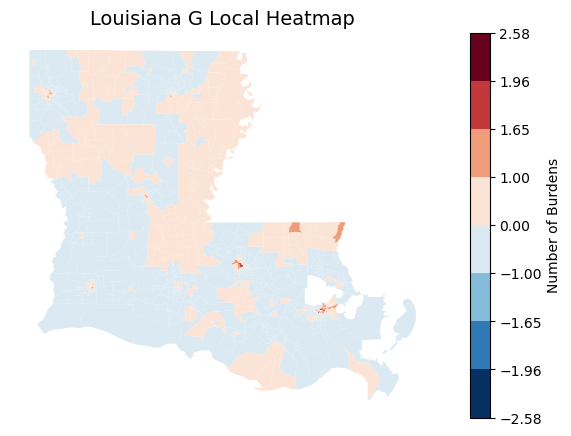

In [18]:
# Define your custom bins (values for standardized_g_star)
bins = [-2.58, -1.96, -1.65, -1, 0, 1, 1.65, 1.96, 2.58]

# Create a colormap
cmap = plt.get_cmap('RdBu_r')

# Create a norm to map standardized_g_star values to the bins
norm = colors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title('Louisiana G Local Heatmap',
            fontsize=14)

# Plot NY state and color by number of spills 
results.plot(ax=ax,
                column='standardized_g_star',
                cmap=cmap,
                norm=norm,
                legend=True,
                legend_kwds={
                    'label':'Number of Burdens'
                })
plt.show()

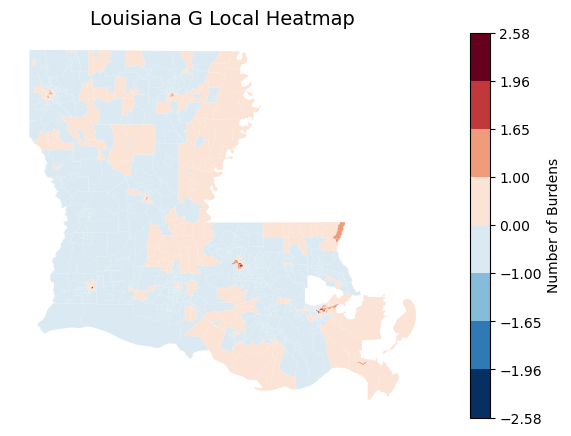

In [19]:
# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title('Louisiana G Local Heatmap',
            fontsize=14)

# Plot NY state and color by number of spills 
results.plot(ax=ax,
                column='standardized_g_star_crit',
                cmap=cmap,
                norm=norm,
                legend=True,
                legend_kwds={
                    'label':'Number of Burdens'
                })
plt.show()

In [20]:
def state_gstar(state):
    # Filter to state
    state_df = comm_v2[comm_v2['State/Territory'] == state]

    # Narrow down to desired columns and rename
    # Can cut these down depending on what we want...
    state_df = state_df[['Census tract 2010 ID', 'Total threshold criteria exceeded', 'Total categories exceeded', 'Identified as disadvantaged without considering neighbors', 'Identified as disadvantaged based on neighbors and relaxed low income threshold only', 'Identified as disadvantaged', 'Percentage of tract that is disadvantaged by area', 'Share of neighbors that are identified as disadvantaged', 'Total population']].rename(columns={
        'Census tract 2010 ID': 'tract_id',
        'Total threshold criteria exceeded':'total_criteria', 
        'Total categories exceeded':'total_burdens', 
        'Identified as disadvantaged without considering neighbors':'dac_wo_neighbors', 
        'Identified as disadvantaged based on neighbors and relaxed low income threshold only':'dac_relaxed_low_income', 
        'Identified as disadvantaged':'dac', 
        'Percentage of tract that is disadvantaged by area':'percent_area_dac', 
        'Share of neighbors that are identified as disadvantaged':'share_of_dac_neighbors', 
        'Total population':'total_population'
    })

    # Print Summary stats for burdens and criteria
    print(f"{state} Burden summary stats:\n{state_df['total_burdens'].describe()}")
    print(f"\n{state} Criteria summary stats:\n{state_df['total_criteria'].describe()}")


    # Filter shapefile to state and select desired columns
    state_geo = v2_geo[v2_geo['SF'] == state]
    state_geo = state_geo[['GEOID10', 'geometry']]

    # Change census tract id type so we can merge later on
    state_geo['GEOID10'] = state_geo['GEOID10'].astype('int64')

    # Merge geometry df and burden df
    state_complete = pd.merge(state_df, state_geo, left_on='tract_id', right_on='GEOID10')

    # At some point, we lost our geodataframe type. Add it back so we can map
    # I think this was because of the merge, I just didn't wanna go back and fix it
    state_complete = gpd.GeoDataFrame(state_complete)


    # LISA
    # Drop geometry NAs
    state_clean = state_complete[(state_complete.geometry.type == 'Polygon') |( state_complete.geometry.type == 'MultiPolygon')]

    # Create weights using Queen method 
    w = lps.weights.Queen(state_clean['geometry'])

    # Run the Getis Ord test for burdens
    gstar_burden = G_Local(state_clean['total_burdens'], w, transform='R') # Set transform=R because the queen weights are row-standardized weights.

    # Run the Getis Ord test for criteria
    gstar_crit = G_Local(state_clean['total_criteria'], w, transform='R')

    # Add burden stats to to a new df
    results = state_clean.drop('GEOID10', axis=1).copy()
    results['standardized_gstar_burd'] = gstar_burden.Zs 
    results['p_norm_burd'] = gstar_burden.p_norm # p-value assuming normal distribution

    # Add criteria stats
    results['standardized_gstar_crit'] = gstar_crit.Zs 
    results['p_norm_crit'] = gstar_crit.p_norm # p-value assuming normal distribution

    #  Results of number of burdens in each bin
    results_95 = results[(abs(results['standardized_gstar_burd']) >=1.96) & (abs(results['standardized_gstar_burd']) < 2.58)]
    results_99 = results[(abs(results['standardized_gstar_burd']) >=2.58)]

    # Results for criteria
    results_95_crit = results[(abs(results['standardized_gstar_crit']) >=1.96) & (abs(results['standardized_gstar_burd']) < 2.58)]
    results_99_crit = results[(abs(results['standardized_gstar_crit']) >=2.58)]

    # Print results
    print(f"\nNumber of tracts in the 95th-99th percentile for burdens: {len(results_95)}")
    print(f"Number of tracts in the 99th+ percentile for burdens: {len(results_99)}")

    print(f"\nNumber of tracts in the 95th-99th percentile for criteria: {len(results_95_crit)}")
    print(f"Number of tracts in the 99th+ percentile for criteria: {len(results_99_crit)}")

    # Plot all four graphs side by side

    # Initialize 2x2 figure grid
    fig, axs = plt.subplots(2, 2, figsize=(9, 5))

    # First plot (top-left)
    axs[0, 0].axis('off')  # Hide axis for a cleaner map
    axs[0, 0].set_title(f"{state} Burdens", fontsize=14)
    results.plot(ax=axs[0, 0], 
                column='total_burdens', 
                cmap='coolwarm', norm=None, legend=True, 
                legend_kwds={'label': 'Number of Burdens'})

    # Second plot (top-right)
    axs[0, 1].axis('off')  # Hide axis for a cleaner map
    axs[0, 1].set_title(f"{state} Criteria", fontsize=14)
    results.plot(ax=axs[0, 1], 
                column='total_criteria', 
                cmap='coolwarm', norm=None, legend=True, 
                legend_kwds={'label': 'Number of Criteria'})


    # Define custom bins for gstar
    bins = [-3, -2.58, -1.96, 0, 1.96, 2.58, 3]

    # Create a colormap
    cmap = plt.get_cmap('coolwarm')

    # Create a norm to map standardized_g_star values to the bins
    norm = colors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

    # Third plot (bottom-left)
    axs[1, 0].axis('off')  # Hide axis for a cleaner map
    axs[1, 0].set_title(f"{state} Gstar Burden Hotspots", fontsize=14)
    results.plot(ax=axs[1, 0], 
                column='standardized_gstar_burd', 
                cmap=cmap, norm=None, legend=True, 
                legend_kwds={'label': 'Standardized G star'})

    # Fourth plot (bottom-right)
    axs[1, 1].axis('off')  # Hide axis for a cleaner map
    axs[1, 1].set_title(f"{state} Gstar Criteria Hotspots", fontsize=14)
    results.plot(ax=axs[1, 1], 
                column='standardized_gstar_crit', 
                cmap=cmap, norm=None, legend=True, 
                legend_kwds={'label': 'Standardized G star'})

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the final figure
    plt.show()



Virginia Burden summary stats:
count    1907.000000
mean        0.599895
std         1.293644
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: total_burdens, dtype: float64

Virginia Criteria summary stats:
count    1907.000000
mean        0.831148
std         1.973809
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.000000
Name: total_criteria, dtype: float64


/Users/katherine/.conda/envs/justice40-env/lib/python3.10/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)



Number of tracts in the 95th-99th percentile for burdens: 40
Number of tracts in the 99th+ percentile for burdens: 27

Number of tracts in the 95th-99th percentile for criteria: 31
Number of tracts in the 99th+ percentile for criteria: 27


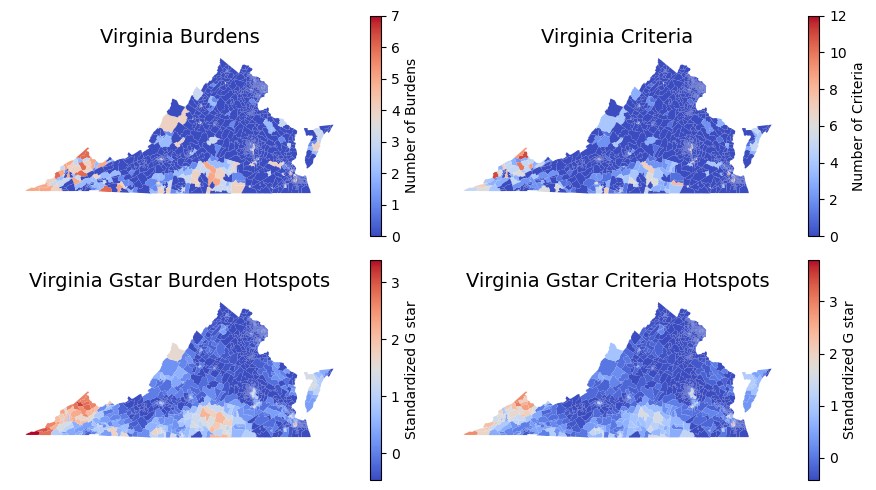

In [21]:
state_gstar("Virginia")